# WindFarmNetwork/Router

This notebook is a practical guide to *OptiWindNet*’s Network/Router API (i.e. high-level API). It covers creating a wind farm model, using different routers (`EWRouter`, `HGSRouter`, `MILPRouter`), and applying key `WindFarmNetwork` functionalities. Specifically, we will:

* Explore the `WindFarmNetwork` class
* Compare available routers and their use cases
* Run a complete optimization example

## ✅ WindFarmNetwork

The `WindFarmNetwork` class is the **central user-facing component** in the OptiWindNet Network/Router-API. It is flexible and extensible, supporting multiple input formats and routers (electrical network optimzers), and is used to model and optimize the electrical network of a wind farm.

### To create a `WindFarmNetwork` instance:

**Required:**

* Turbine and substation coordinates *(see [Data Input](a01_data_input.ipynb) for formats)*
* Cable data (capacities and costs, or at least maximum capacity as a single number)

**Optional:**

* Borders and obstacles: to add spatial constraints
* Router: optimization strategy (defaults to `EWRouter` if not specified)
* verbose: log/hide logging messages (default to `Fault`).

### Key Responsibilities

| Feature                      | Description                                                                                                                                    |
| ---------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------- |
| **Initialization & Parsing** | Accepts turbine/substation coordinates or the Location geometry `L` (Can be constructed from YAML, PBF, or WindIO formats for integration with real-world datasets), validates cable data, and constructs the internal graph structure.                 |
| **Optimization**             | Interfaces smoothly with different routers (`EWRouter`, `HGSRouter`, `MILPRouter`) to optimize the network (cable routing) for cost and cable length. |
| **Visualization**            | Provides plotting functions for location geometry, links, mesh, and the optimized network.                           |
| **Gradient & Update Graph**  | Computes gradients for optimization and allows updating the electrical network using a compact "terse link" format.                                   |


### Example Workflow

```python
# Initialize with coordinates and cable types
wfn = WindFarmNetwork(
    cables=[(2, 1500.0), (5, 1800.0)],
    turbinesC=...,
    substationsC=...,
)

# Optimize electrical network using the default router (EWRouter)
wfn.optimize()

# Access total cost or cable length
total_cost = wfn.cost()
total_length = wfn.length()

# Visualize network
wfn.plot() # or simply wfn if you are running on notebooks
```

## 🧭 **Router**

In OptiWindNet, a `Router` is used to compute the optimal network (cable routing) of the wind farm’s electrical network. Given turbine and substation positions (layout), available cable options, and routing constraints, a router determines *which turbines connect to which substations* and how cables should be laid to *minimize length (and consequently cost)*.

### Currently Available Routers

The routers currently included in the `optiwindnet.api` module are:

* **EWRouter**

  * *Fastest option* — completes in a fraction of a second
  * Great for quick network generation
  * Produces only **branched-topology** solutions
  * Heuristic method (EW = modified Esau-Williams) — solutions may be far from the optimum

* **HGSRouter**

  * *Still fast* — can provide high-quality solutions in **0.5–2 seconds**
  * Produces only **radial-topology** solutions (no branching)
  * A maximum number of feeders can be enforced
  * Meta-heuristic method (HGS = Hybrid Genetic Search)

* **MILPRouter**

  * Delivers solutions with **quality guarantees** (a bound on the distance from the optimum)
  * May take a **few to several minutes** depending on the problem size and quality required
  * Full set of model options to choose from
  * Should be used when optimality is more important than speed
  * MILP = Mixed Integer Linear Programming

## Run an example

In this section we will:
- Create a simple wind farm network
- Use heuristic and MILP optimization
- Explore key methods such as:
  - `.optimize()`
  - `.plot()`
  - `.cost()`, `.length()`
  - `.terse_links()`, `.update_from_terse_links()`
  - `.gradient()`
  - `.get_network()`
  - `.add_buffer()`

### Create a `WindFarmNetwork` instance

Import required modules

In [1]:
import numpy as np
from optiwindnet.api import WindFarmNetwork, EWRouter, MILPRouter, ModelOptions

In [2]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

#### Load location data

OptiWindNet operates on location geometries, which define turbine and substation positions (plus optional borders/obstacles).

You can load a location from:
- `.yaml` or `.osm.pbf` files;
- The included locations repository;
- Your own coordinate arrays.

For more details see [Data Input](a01_data_input.ipynb).

We start with a simple geometry (5 turbines and 1 substation), and define a simple set of cables.

In [3]:
wfn = WindFarmNetwork(
    cables=[(2, 1500.0), (5, 1800.0)],
    turbinesC=np.array([[0, 0], [1, 1], [2, 0], [3, 1], [4, 0]]),
    substationsC=np.array([[2, -2]]),
    borderC=np.array([[0, -3], [0, 2], [4, 2.1], [5, 1], [4, -3]]),
    obstacleC_=[np.array([[0.2, -2.5], [1.5, -2.5], [0.2, -1]])]
)

##### Plot location

> **Note:** Many of the Jupyter notebooks provided include SVG figures as output. To ensure these visuals are displayed correctly in JupyterLab or Jupyter Notebook, make sure the notebook is marked as **trusted**.
> *In JupyterLab, you can do this by pressing* `Ctrl + Shift + C` *and selecting* **Trust Notebook**.

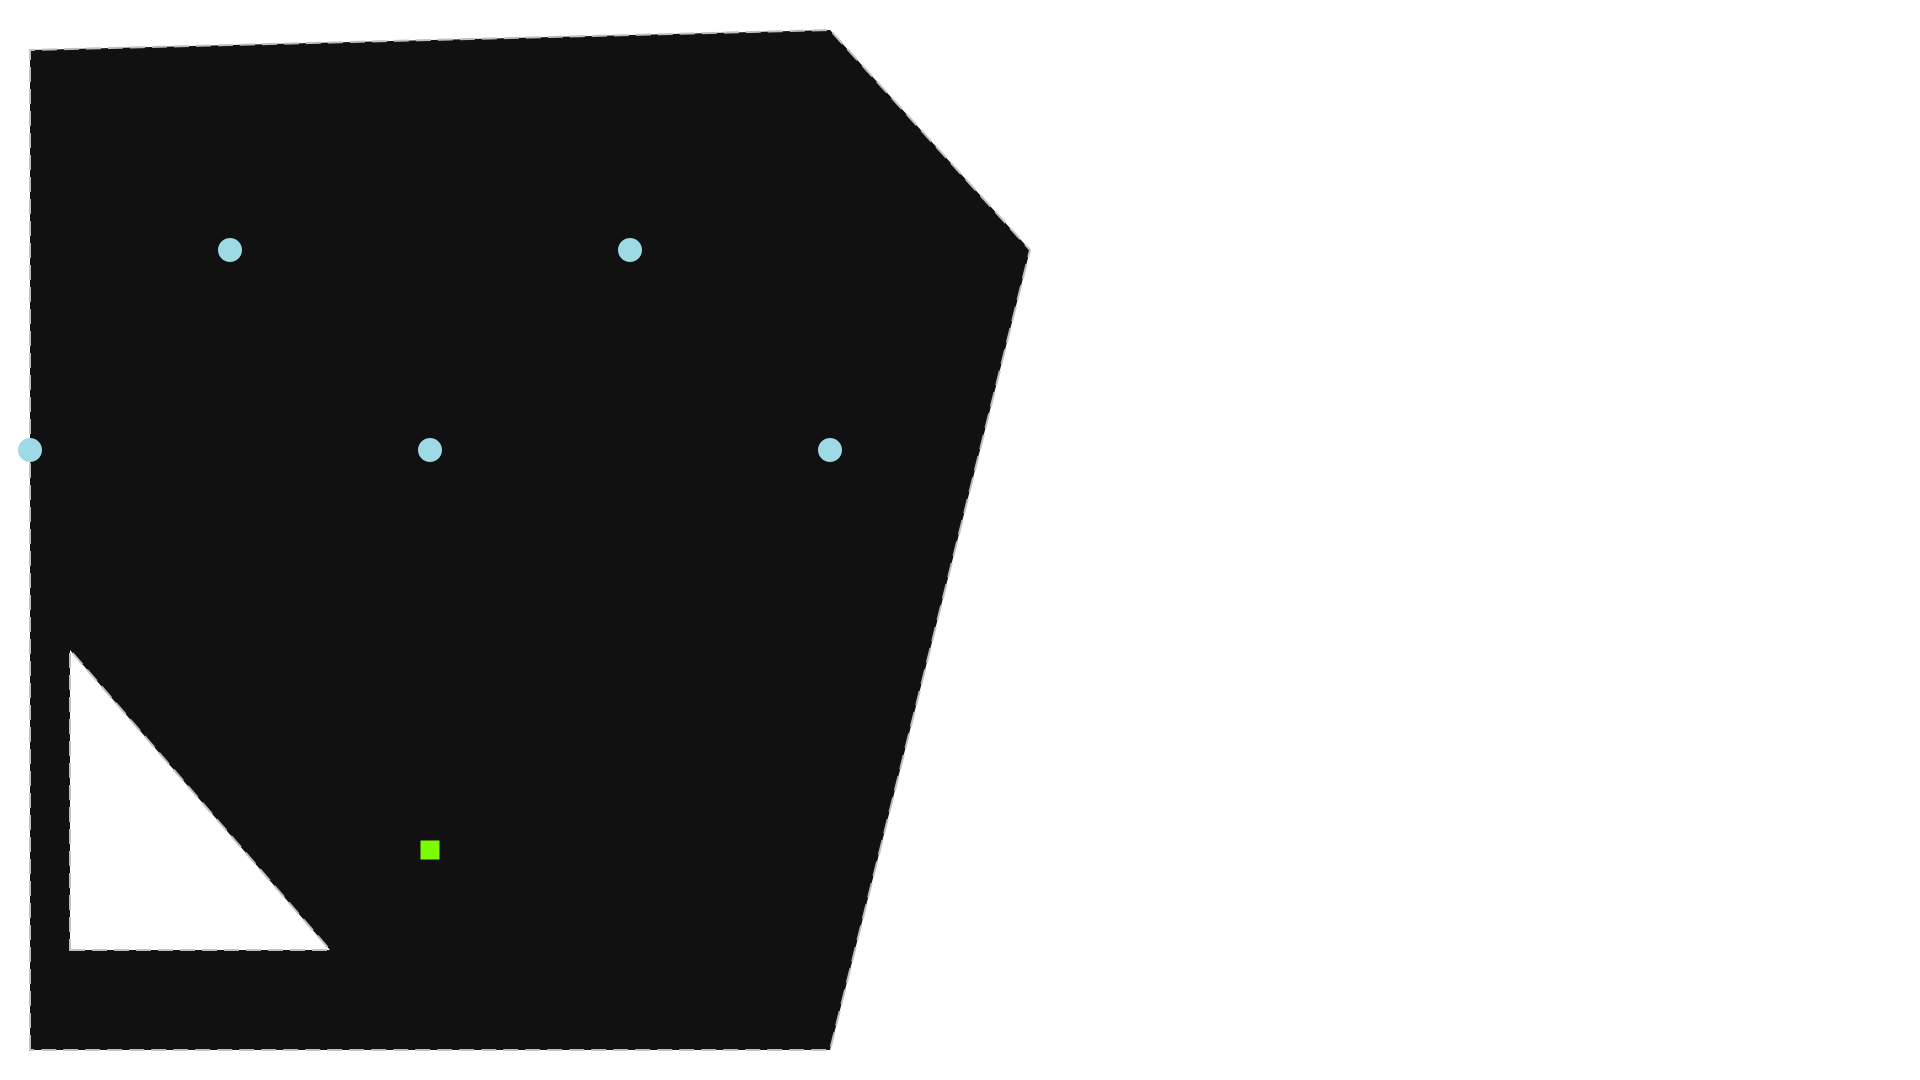

In [4]:
wfn

### Method: `optimize(router=...)`

This is the main method that optimizes the electrical network using the given router (heuristic, metaheuristic or MILP).
 > Note that the router could be passed directly to `WindFarmNetwork(router=...)`.

#### Use a heuristic router (Esau-Williams)

In [5]:
wfn.optimize(router=EWRouter())

array([ 1,  2, -1,  2,  3])

Plot the result

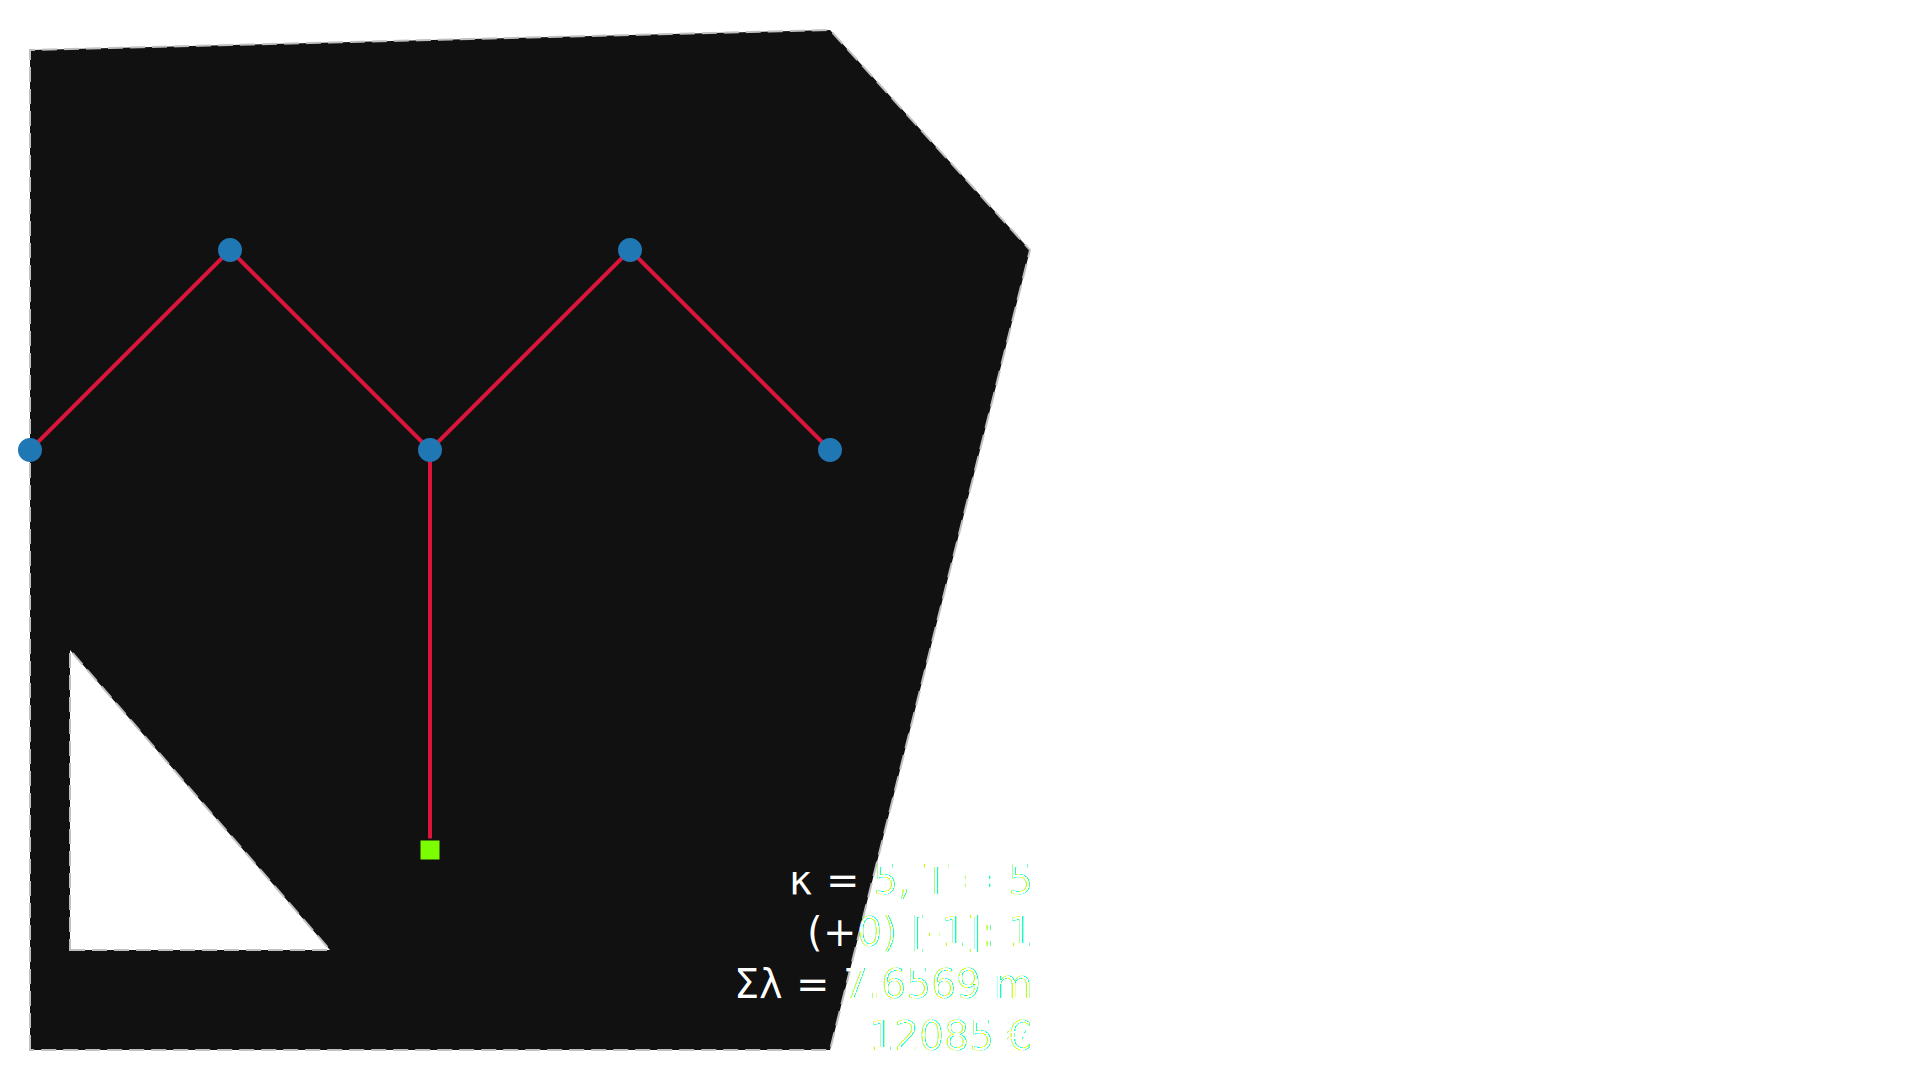

In [6]:
wfn

#### Use a MILP router with full control over topology and feeders

The solution from the previous call to `wfn.optimize()` is stored within the `wfn` object.
If this solution is *feasible under the current `MILPRouter` settings*, it will be *automatically used as a warm start*.
Otherwise, if it does not meet the current `ModelOptions` constraints, it will be *ignored*, and the MILP solver will start from scratch.



    - branched network incompatible with model option: topology="radial"



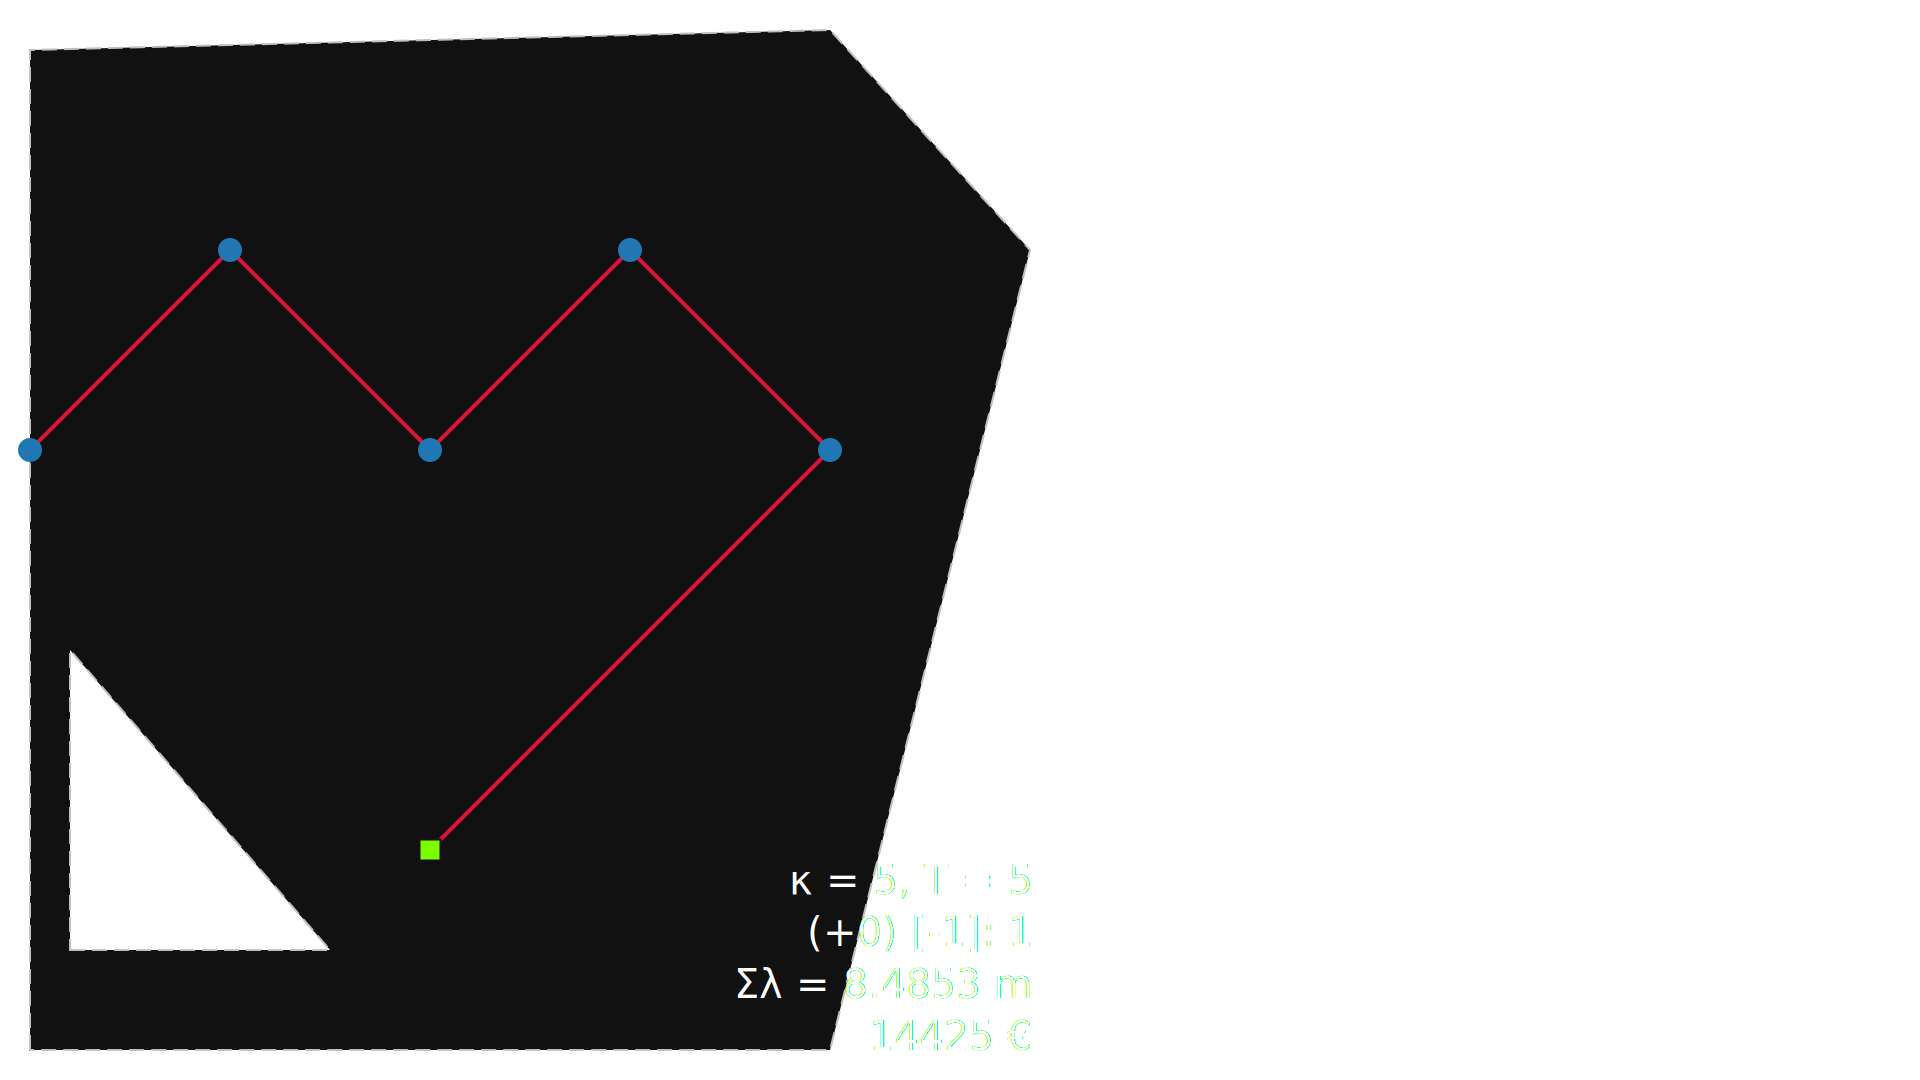

In [7]:
model_opts = ModelOptions(
    topology='radial',
    feeder_limit='minimum',
    feeder_route='straight',
)
wfn.optimize(
    router=MILPRouter(
        solver_name='ortools',
        time_limit=2,
        mip_gap=0.01,
        model_options=model_opts
    ),
    verbose=True,
)
wfn

### Method: `plot()` and Variants

These methods help you visualize different stages of the optimization:

- `plot_location()`: plot turbine/substation coordinates and borders
- `plot()`: plot optimized electrical network

> For more details, see the [Plotting](a04_Plotting.ipynb) tutorial.

<Axes: >

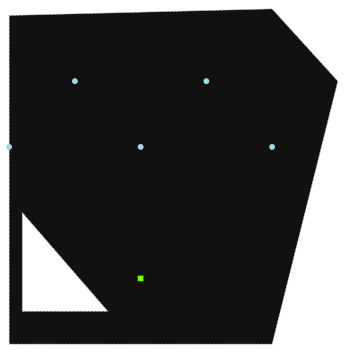

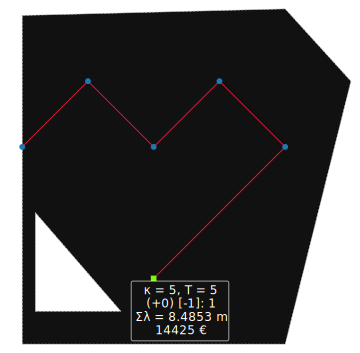

In [8]:
wfn.plot_location()
wfn.plot() # wfn will do the same on notebooks (and if no G is available it will display L)

### Method: `cost()` and `length()`

Returns the total cost and cable length of the optimized network.

In [9]:
print("Network cost:", wfn.cost())
print("Network length:", wfn.length())

Network cost: 14424.97833620557
Network length: 8.485281374238571


### Method: `terse_links()`

A terse link is a compact way to describe how each turbine is connected in the electrical network. It’s just a list (or array) where:

* Each position `i` represents turbine `i`

* The value at position `i` is the node that turbine `i` connects to
(this could be another turbine or a substation)

In [10]:
terse = wfn.terse_links()
print("Terse link array:", terse)

Terse link array: [ 1  2  3  4 -1]


### Method: `update_from_terse_links()`

`update_from_terse_links()` allows you to reconstruct the network from a known `terse_link`, optionally updating coordinates. This method assumes a **valid and feasible network**, so it’s your responsibility to ensure that:
* The connections form a proper **feeder tree**
* Every turbine is (indirectly or directly) connected to a **substation**
* Capacity constraints are not violated

Suppose we have a wind farm with:
* **5 turbines** → nodes `0, 1, 2, 3, 4`
* **1 substation** → node `-1` (*Note: In optiwindnet, substations are assigned negative indices*)

We want the following connections:
* Turbine 0 → Substation (-1)
* Turbine 1 → Turbine 0
* Turbine 2 → Substation (-1)
* Turbine 3 → Turbine 2
* Turbine 4 → Turbine 3

This gives us the `terse_links` array:

```python
terse_links = [-1, 0, -1, 2, 3]

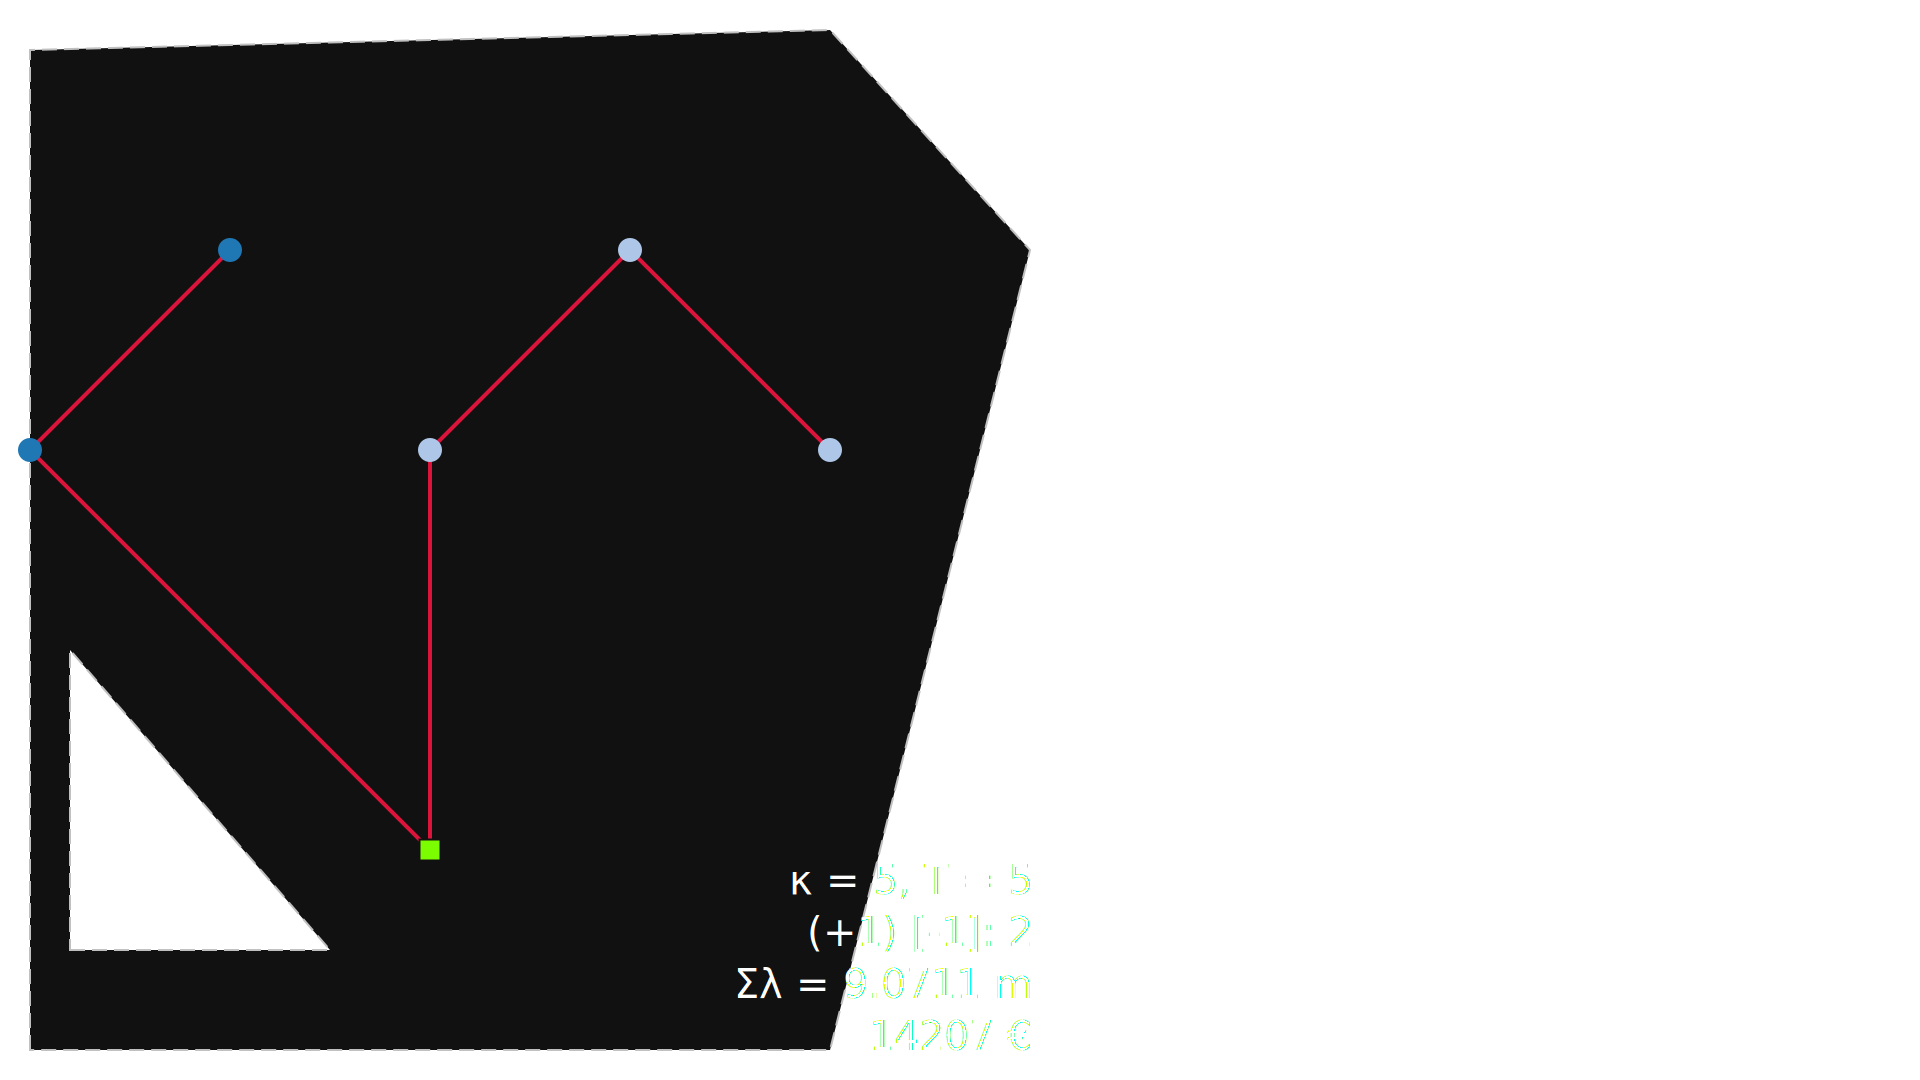

In [11]:
new_terse_links = np.array([-1, 0, -1, 2, 3])

# Apply the new configuration
wfn.update_from_terse_links(new_terse_links)

# Visualize the updated network (cable routing)
wfn


### Method: `gradient()`

This method computes the gradient of the cost or length with respect to turbine/substation positions.
Useful for hybrid optimization or sensitivity analysis.
 > Note: default of `gradient_type` is `length`.

In [12]:
print('--- gradient_type=length ---\n')
grad_turb, grad_subs = wfn.gradient()
print("Gradient (w.r.t. turbines):\n", grad_turb, "\n")
print("Gradient (w.r.t. substations):\n", grad_subs)
print('\n')
print('--- gradient_type=length ---\n')
grad_turb, grad_subs = wfn.gradient(gradient_type='cost')
print("Gradient (w.r.t. turbines):\n", grad_turb, "\n")
print("Gradient (w.r.t. substations):\n", grad_subs)

--- gradient_type=length ---

Gradient (w.r.t. turbines):
 [[-1.41421356  0.        ]
 [ 0.70710678  0.70710678]
 [-0.70710678  0.29289322]
 [ 0.          1.41421356]
 [ 0.70710678 -0.70710678]] 

Gradient (w.r.t. substations):
 [[ 0.70710678 -1.70710678]]


--- gradient_type=length ---

Gradient (w.r.t. turbines):
 [[-2121.32034356     0.        ]
 [ 1060.66017178  1060.66017178]
 [-1060.66017178   739.33982822]
 [    0.          2121.32034356]
 [ 1060.66017178 -1060.66017178]] 

Gradient (w.r.t. substations):
 [[ 1060.66017178 -2860.66017178]]


### Method: `get_network()`

This method returns the **final optimized network** as a **structured NumPy array**, where each row represents an edge in the network.

Each edge includes detailed attributes such as:

* **`src`**: index of the source node
* **`tgt`**: index of the target (destination node)
* **`length`**: physical cable length
* **`load`**: electrical load carried through the cable (number of turbines)
* **`cable`**: index of the cable type used (e.g., 0 for first type in cable list)
* **`cost`**: cost associated with the used cable (if cost is provided by the user)

In [13]:
network_data = wfn.get_network()
network_data[:2]  # preview only first few edges

array([(1,  0, 1.41421356, 1., 0), (0, -1, 2.82842712, 2., 0)],
      dtype=[('src', '<i8'), ('tgt', '<i8'), ('length', '<f8'), ('load', '<f8'), ('cable', '<i8')])

### Method: `add_buffer()`

This method redefines the border and obstacles by expanding the borders and shrinking the obstacles; useful when turbines are near edges or when integrating with tools like TopFarm|

In [14]:
wfn.add_buffer(buffer_dist=0.5)

Buffering by 0.50 completely removed the obstacle at index 0. For visual comparison use plot_original_vs_buffered().


<Axes: title={'center': 'Original and Buffered Shapes'}>

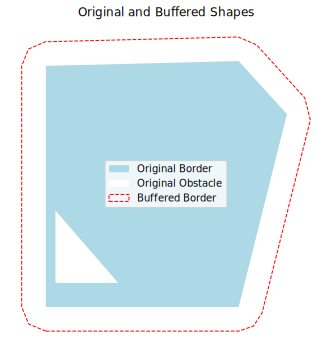

In [15]:
wfn.plot_original_vs_buffered()

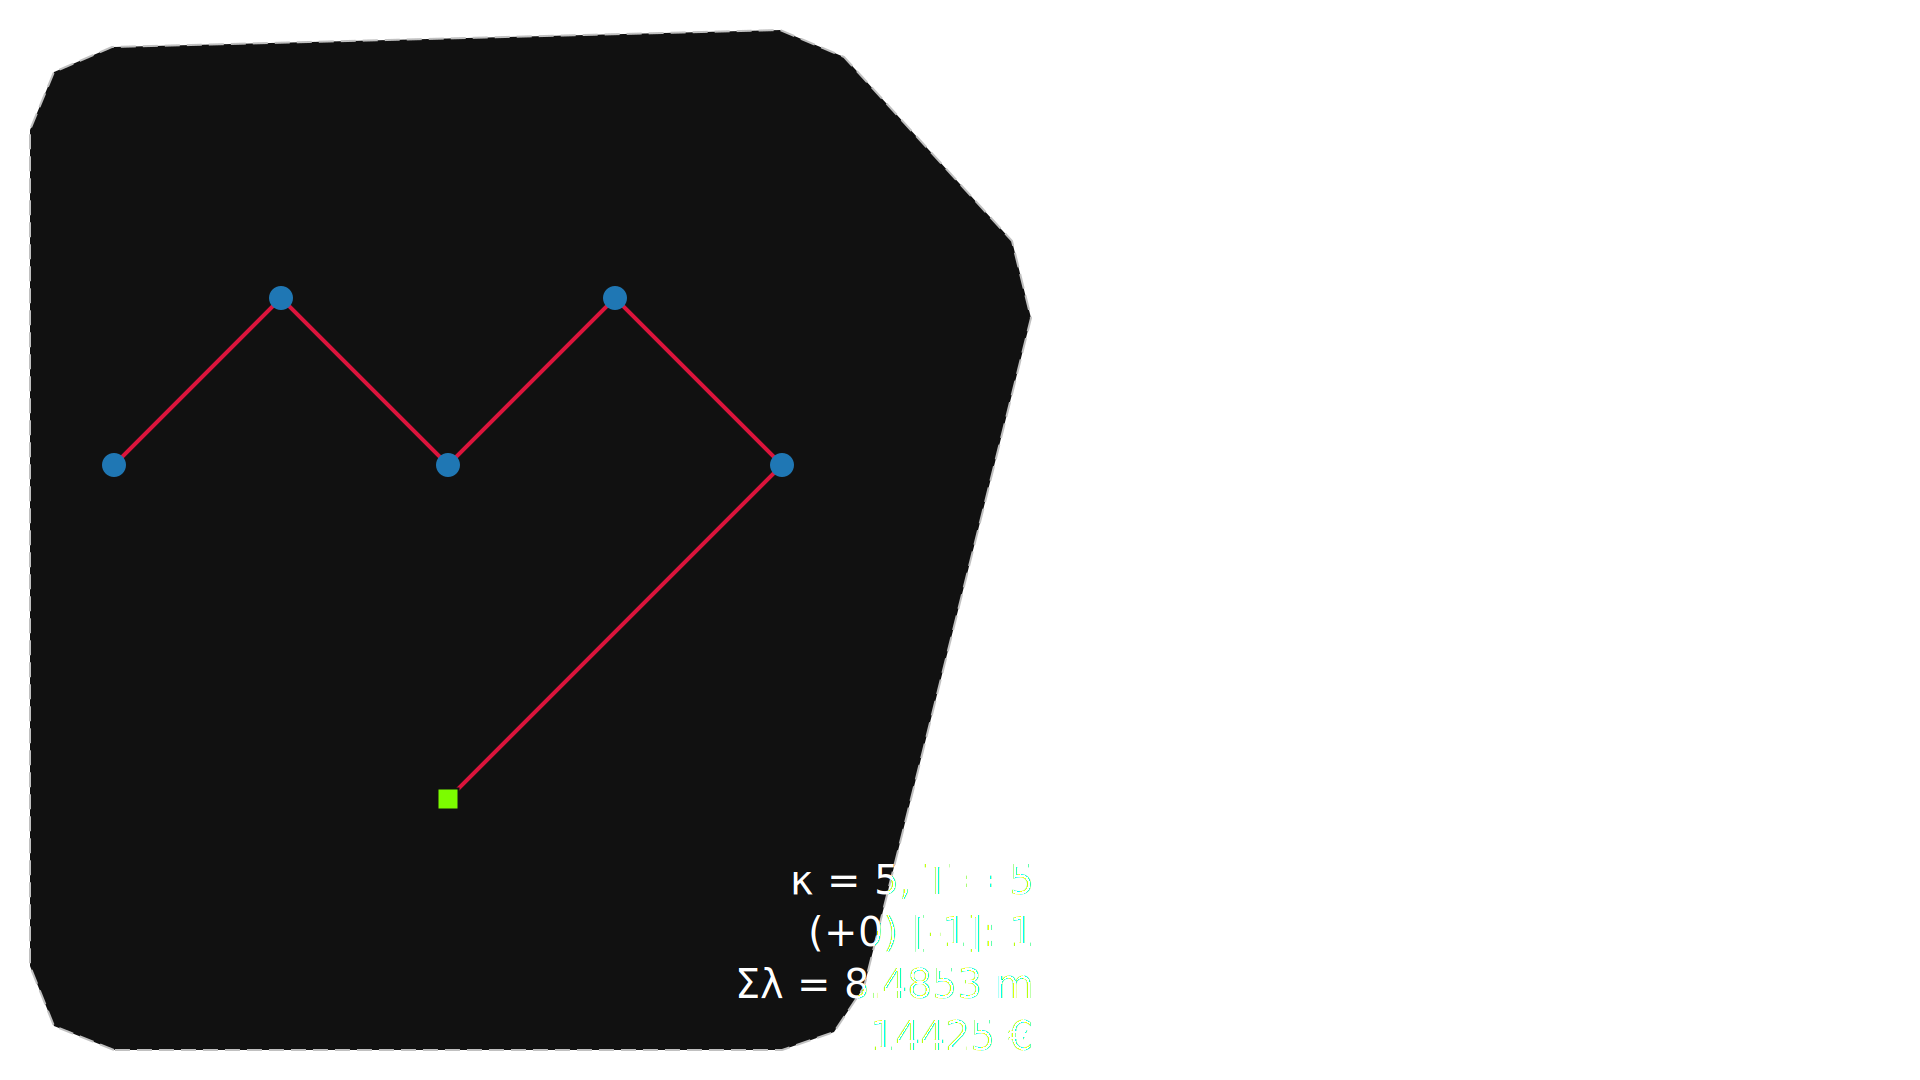

In [16]:
wfn.optimize()
wfn

### In this section:

we explored the most useful methods of the `WindFarmNetwork` class:

| Method | Purpose |
|--------|---------|
| `optimize()` | Run optimization with a router |
| `plot()` | Visualize the network |
| `cost()`, `length()` | Get total cost and length |
| `terse_links()` | Get compact link encoding |
| `update_from_terse_links()` | Apply terse links manually |
| `gradient()` | Compute network's gradient |
| `get_network()` | Export the optimized network data |
| `add_buffer()`| Expand border - Shrink obstacles|

For deeper insights into individual methods, refer to the dedicated notebooks provided.
